# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

### Abstract

GRASS is an open-source geospatial processing engine. With over 400 tools available in the core distribution and an additional 400+ tools available as extensions, GRASS has broad applicability in the Earth Sciences and geomorphometry in particular. In this workshop, we will give an introduction to GRASS and demonstrate some of the geomorphometry tools available in GRASS. Specifically, we will show how to compute stream extraction uncertainty using a workflow adapted from Hengl (2007) [1] and Hengl (2010) [2]. In this tutorial, we will:
* [Create a new GRASS project](#start)
* [Download and import elevation data](#data) of near Perugia using GRASS data fetching tools
* Use R’s kriging functions (gstat) to create 100 iterations of a DEM
* Use GRASS tools to extract streams from each of the 100 DEMs to compute stream uncertainty

Check out the publication associated with the notebook on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15283714.svg)](https://doi.org/10.5281/zenodo.15283714)


<a name="start"></a>

---


### Start GRASS and Create a New Project

The following cell installs GRASS from the ubuntugis-unstable ppa. It will take a minute to run.

In [ ]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

We can check GRASS installed and see what version we have using:

In [ ]:
!grass --version

Import Python libraries.

In [9]:
import sys
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image
from ipyleaflet import ImageService, WMSLayer, Marker
from ipyleaflet.projections import projections
import xyzservices

We are going to import the GRASS Python API (`grass.script`) and the GRASS Jupyter package (`grass.jupyter`). But first, we'll need to ask `grass` to check it's `--config` to see where the python packages are then add them to the system path before we can import them.

We use `subprocess.check_output` to find the path and `sys.path.append` to add it to the path.

In [3]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

Then, we can import the Python API and GRASS Jupyter packages.

In [4]:
import grass.script as gs
import grass.jupyter as gj

Now, we create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 32632](https://epsg.io/32632), CRS WGS 84/UTM zone 32N (EPSG:32632).

In [ ]:
gs.create_project("geomorphometry_workshop", epsg="32632")

We start a GRASS session in our new project.

In [15]:
gj.init("geomorphometry_workshop");

Finally, let's set our computational region using [`g.region`](https://grass.osgeo.org/grass85/manuals/g.region.html). The computational region will determine what data is imported from the cloud so we need to set it before continuing.

Upon creating a project, the computational region is empty.

In [16]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      1
south:      0
west:       0
east:       1
nsres:      1
ewres:      1
rows:       1
cols:       1
cells:      1



There are lots of ways to set the computional region, from a georeferenced file or existing data layer to relative operations grow which adds cells around the previous region. Here, we set our computational region with coordinates and set the resolution to 10 meters.

In [20]:
aoi_bbox = {
	"north": 4779210,
	"south": 4778120,
	"west": 779180,
	"east": 780630
}

print(
    gs.read_command(
        "g.region", n=aoi_bbox["north"], s=aoi_bbox["south"], e=aoi_bbox["east"], w=aoi_bbox["west"], res=10, flags="p"
    )
)

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805



<a name="data"></a>

---

## Download and Import Data

We're going to use a DEM from the TINItaly dataset. Let's get an overview of the dataset using a quick WMS visualization.

In [21]:
tinitaly_wms = WMSLayer(
    name="TINItaly_1.1 HSV (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_hsv",
    format="image/png",
    transparent=True,
    attribution="HSV Elevation Data © 2023 TINItaly 1.1",
)

tinitaly_slope = WMSLayer(
    name="TINItaly_1.1 Slope (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_slope",
    format="image/png",
    transparent=True,
    attribution="Slope Data © 2023 TINItaly 1.1",
)

nasa_wms = WMSLayer(
    name="NASA SRTM RAMP2 TOPO (WMS)",
    url="https://neo.gsfc.nasa.gov/wms/wms?service=WMS",
    layers="SRTM_RAMP2_TOPO",
    format="image/png",
    transparent=True,
    styles="rgb",
    attribution="SRTM RAMP2 TOPO © 2025 NASA ",
)

perugia = Marker(
    name="Perugia (Marker)",
    location=(43.11203, 12.38914),
    draggable=False,
    title="Perugia",
    alt="Perugia",
    # icon="fa-flag",
)

In [22]:
nasa_basemap = "NASAGIBS BlueMarble"
m = gj.InteractiveMap(height=600, width=800, tiles=nasa_basemap, use_region=True)
m.map.add(tinitaly_wms)
m.map.add(tinitaly_slope)
m.map.add(nasa_wms)
m.map.add(perugia)
m.add_layer_control()
m.map.zoom = 6
m.map.center = (43.11203, 12.38914)
display(m.show())

Map(center=[43.11203, 12.38914], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Now we can import our DEM. We will use the [r.import](https://grass.osgeo.org/manuals/grass85/r.import.html) command to import a DEM file. The DEM file is a [Cloud Optimized GeoTIFF (COG)](https://cogeo.org/), and we will specify the output name as "dem". *r.import* will automatically reproject the DEM to the project's CRS.

In [23]:
gs.run_command(
    "r.import",
    input="https://storage.googleapis.com/geomorphometry/w47575_s10.cog.tif",
    output="dem",
    title="TINItaly DEM 10m",
    resample="bicubic_f",
    resolution="region",
    extent="region",
    overwrite=True,
)

In [26]:
print(gs.read_command("r.info", map="dem"))

 +----------------------------------------------------------------------------+
 | Map:      dem                            Date: Mon May  5 19:36:59 2025    |
 | Mapset:   PERMANENT                      Login of Creator: root            |
 | Project:  geomorphometry_workshop                                          |
 | DataBase: /content                                                         |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    FCELL                Semantic label: (none)                |
 |   Rows:         109                                                        |
 |   Columns:      145                  

In [28]:
print(gs.read_command("r.univar", map="dem", flags="e"))

total null and non-null cells: 15805
total null cells: 0

Of the non-null cells:
----------------------
n: 15805
minimum: 184.859
maximum: 361.85
range: 176.991
mean: 246.02
mean of absolute values: 246.02
standard deviation: 51.9923
variance: 2703.19
variation coefficient: 21.1334 %
sum: 3888344.66534424
1st quartile: 193.445
median (odd number of cells): 240.261
3rd quartile: 290.256
90th percentile: 318.982



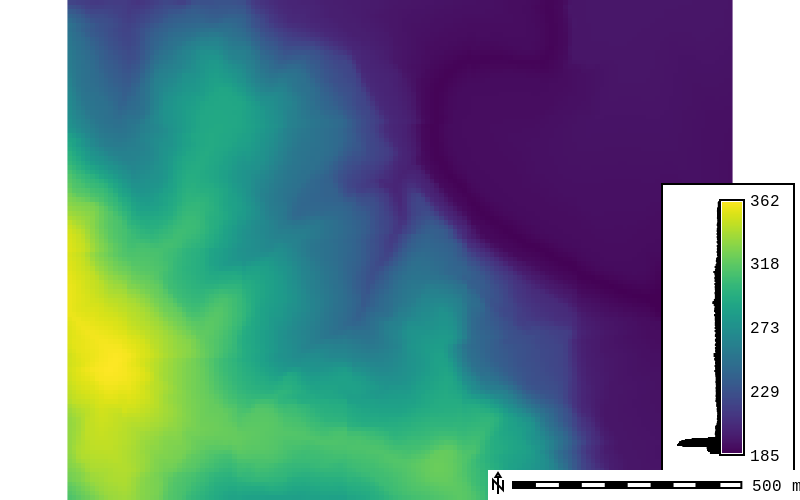

In [43]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_rast(map="dem")
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

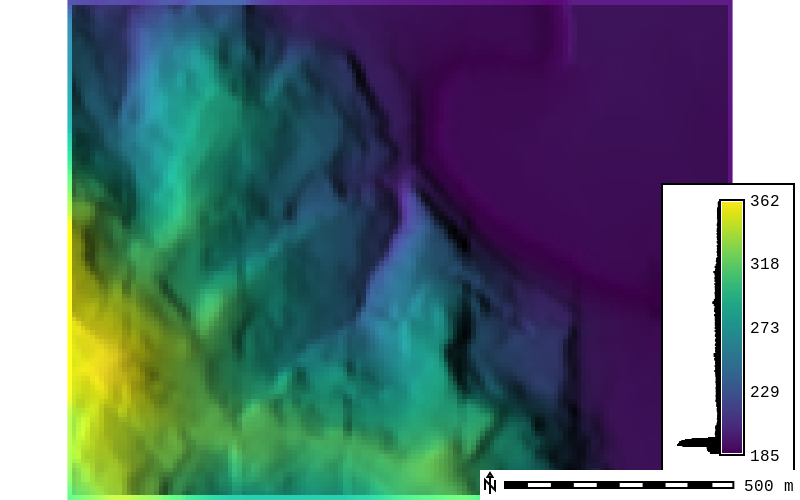

In [42]:
gs.run_command("r.relief", input="dem10m", output="relief", scale=1, zscale=1)
m = gj.Map(use_region=True, height=500, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="60,6", fontsize=16, flags="n")
m.show()


Sample Points

TODO: Statified sampling by landcover to mimic Lidar? Like lower frequency in heavily vegetated areas and none in water/buildings?

In [ ]:
# print(
#     gs.read_command(
#         "g.region", n=aoi_bbox["north"], s=aoi_bbox["south"], e=aoi_bbox["east"], w=aoi_bbox["west"], res=10, flags="pa"
#     )
# )
gs.run_command("r.random", input="dem", vector="elevrand", n=1000, flags="s")

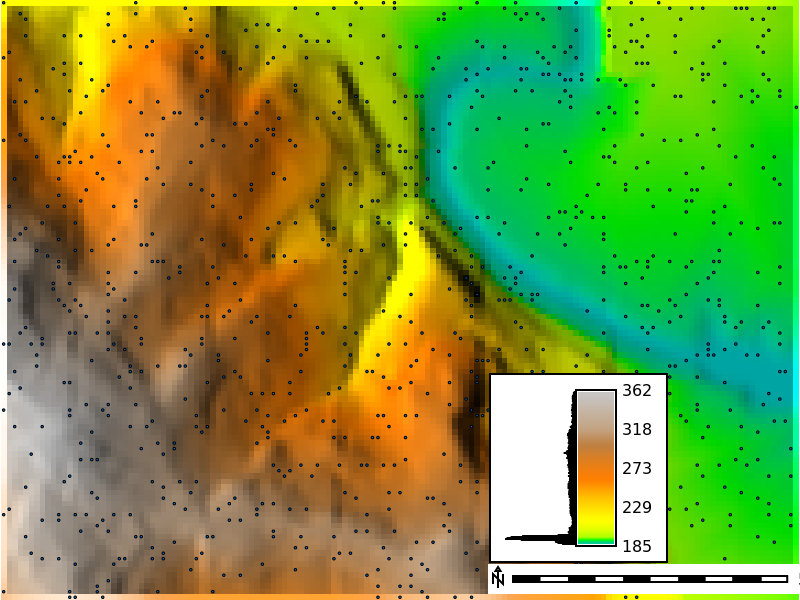

In [ ]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="dem", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()



In [ ]:
gs.run_command("r.slope.aspect", elevation="dem", slope="slope", aspect="aspect", overwrite=True)

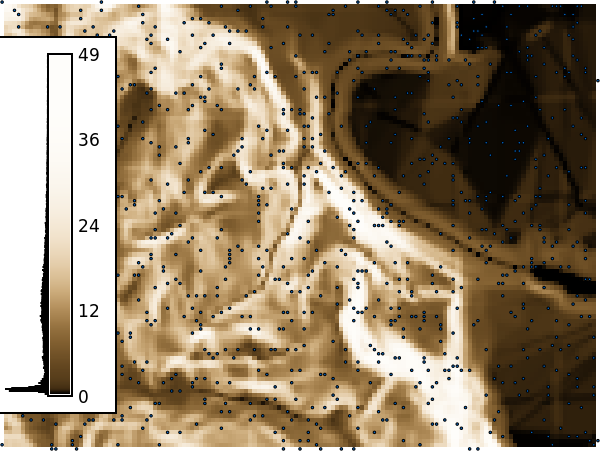

In [ ]:
gs.run_command("r.colors", map="slope", color="sepia", flags="e")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="slope", flags="bds")
m.show()

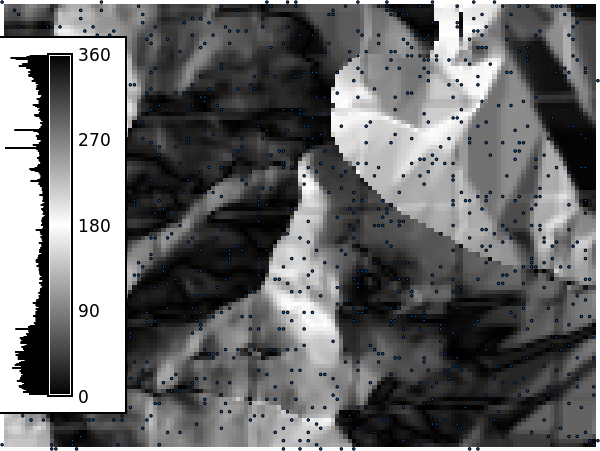

In [ ]:
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="aspect", flags="bds")
m.show()

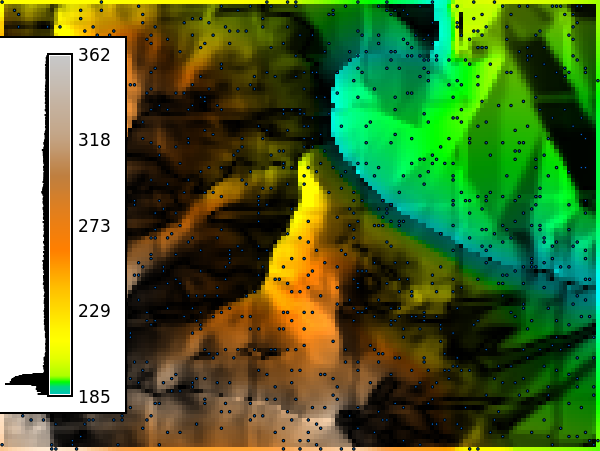

In [ ]:
m = gj.Map(use_region=True)
m.d_shade(shade="aspect", color="dem", brighten=30)
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="dem", flags="bds")
m.show()

## Move to R for Kriging

Set up R.

Load rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R.

In [ ]:
%load_ext rpy2.ipython

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [ ]:
%%R
system("apt-get install r-cran-sf")

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [ ]:
%%R
system("apt-get install r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

We also need the rgrass package which is distributed on GitHub.

In [ ]:
%%R
R.version.string

[1] "R version 4.5.0 (2025-04-11)"


Load libraries.
- Tell R to use the system packages

In [ ]:
%%R

library(sf)
print(packageDescription("sf"))
library(gstat)
print(packageDescription("gstat"))
library(terra)
print(packageDescription("terra"))
library(rgrass)
print(packageDescription("rgrass"))


Package: sf
Version: 1.0-6
Title: Simple Features for R
Authors@R: c(person(given = "Edzer", family = "Pebesma", role =
        c("aut", "cre"), email = "edzer.pebesma@uni-muenster.de",
        comment = c(ORCID = "0000-0001-8049-7069")), person(given =
        "Roger", family = "Bivand", role = "ctb", comment = c(ORCID =
        "0000-0003-2392-6140")), person(given = "Etienne", family =
        "Racine", role = "ctb"), person(given = "Michael", family =
        "Sumner", role = "ctb"), person(given = "Ian", family = "Cook",
        role = "ctb"), person(given = "Tim", family = "Keitt", role =
        "ctb"), person(given = "Robin", family = "Lovelace", role =
        "ctb"), person(given = "Hadley", family = "Wickham", role =
        "ctb"), person(given = "Jeroen", family = "Ooms", role = "ctb",
        comment = c(ORCID = "0000-0002-4035-0289")), person(given =
        "Kirill", family = "M\u00fcller", role = "ctb"), person(given =
        "Thomas Lin", family = "Pedersen", role = 

Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [ ]:
%%R

# Set GRASS region
# rgrass::execGRASS("g.region", n="4780470", s="4774720", e="783130", w="777410", flags = c("p","a"))

# Read vector elevation points from GRASS
elevrand <- rgrass::read_VECT("elevrand")
rgrass::execGRASS("g.region", flags = c("p"))
# Ensure the directory exists
# if (!dir.exists("cgsSim/data")) {
#   dir.create("cgsSim/data", recursive = TRUE)
# }

# saveRDS(elevrand, file = "cgsSim/data/elevrand.rds")


Exporting 1000 features...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96v.out.ogr complete. 1000 features (Point type) written to <elevrand> (GPKG
format).
projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805


In [ ]:
%%R

coords <- terra::geom(elevrand)[, c("x", "y")]
dists <- as.matrix(dist(coords))
max_dist <- max(dists)

# Best practice
# Default cutoff is 0.5 but this is too small for our data
cutoff <- 0.9 * max_dist
width <- cutoff / 15
print(paste("Using cutoff:", cutoff, "and width:", width))

[1] "Using cutoff: 1609.26442824043 and width: 107.284295216029"


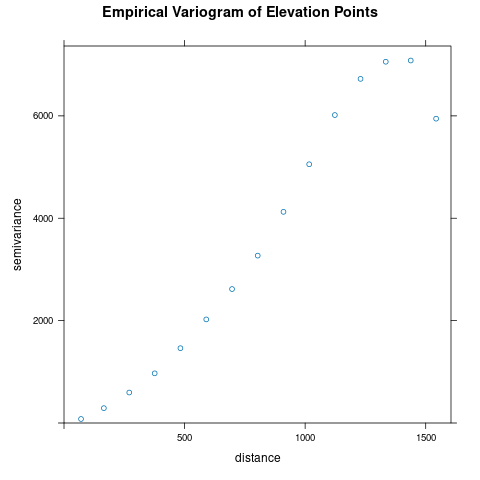

In [ ]:
%%R
# Convert to sf-style data frame for gstat
elev_df <- terra::as.data.frame(elevrand, geom = "XY")
# saveRDS(elev_df, file = "cgsSim/data/dataframe.rds")
g <- gstat::gstat(formula = value ~ 1, locations = ~x + y, data = elev_df)
# saveRDS(g, file = "cgsSim/data/gstat.rds")

vg <- gstat::variogram(g, cutoff = cutoff, width = width)
# saveRDS(vg, file = "cgsSim/data/variorgram.rds")

plot(vg, main = "Empirical Variogram of Elevation Points")

In [ ]:
%%R
# Load the cgsSim package
devtools::load_all("cgsSim/")

# Fit kappa
fit_kappa <- optimize_kappa(vg)
fit_kappa

ℹ Loading cgsSim
$model
  model       psill    range    kappa
1   Nug    42.52473    0.000 0.000000
2   Mat 77372.14681 3809.355 1.056513

$kappa
[1] 1.056513

$SSErr
[1] 14720.69



TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

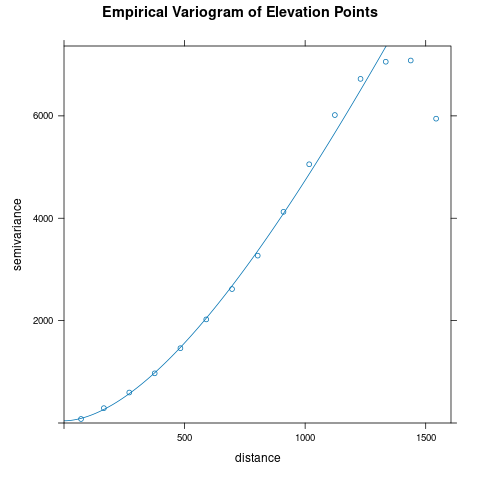

In [ ]:
%%R

plot(vg, model = fit_kappa$model, main = "Empirical Variogram of Elevation Points")

In [ ]:
%%R
vc <- variogram(g, cloud=TRUE)

# Plot
plot(vc$dist, vc$gamma, pch="+", cex=1.5, xlab="Distance [m]", ylab="Semivariance", main="Semivariogram Cloud", col = rainbow(length(vc$gamma))[rank(vc$gamma)])
points(fit_kappa$model[,2:3], type= "l", col='black')

In [ ]:
%%R
# Load the cgsSim package
devtools::load_all("cgsSim/")

# Fit variogram automatically
fit_result <- auto_variogram_fit(elev_df, cutoff = cutoff, width = width, kappa = fit_kappa$kappa)


ℹ Loading cgsSim
[1] 244.806
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary krigi

In [ ]:
%%R

saveRDS(fit_result$vgm_model, file = "cgsSim/data/vgm_model.rds")

head(fit_result)

$psill
psill_start 
   1282.026 

$range
range_start 
   5984.591 

$nugget
nugget_start 
    25.64051 

$kappa
[1] 0.7017462

$mse
[1] 56.00105

$vgm_model
  model      psill    range     kappa
1   Nug   25.64051    0.000 0.0000000
2   Mat 1282.02566 5984.591 0.7017462



In [ ]:
%%R
# cgsSim package
plot_auto_variogram(vg, fit_result$vgm_model)

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'fit_result' not found


RInterpreterError: Failed to parse and evaluate line '# devtools::load_all("cgsSim/")\n# vfit <- gstat::fit.variogram(vg, model = vgm_model, fit.kappa = TRUE)\n# Optimize the kappa parameter\n# f = function(x) attr(m.fit <<- fit.variogram(vg, model = vgm(,"Mat",nugget=NA,kappa=x)),"SSErr")\n# result <- optimize(f, c(0.1, 5))\n# print(result$minimum)\n# vfit <- gstat::fit.variogram(vg, model = fit_result$vgm_model, fit.kappa = FALSE)\n# plot(vg, model = vfit, main = "Empirical Variogram with Fitted Model")\nplot_auto_variogram(vg, fit_result$vgm_model)\n'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 'fit_result' not found"

In [ ]:
%%R
devtools::load_all("cgsSim/")



# vfit <- gstat::fit.variogram(vg, model = fit_result$vgm_model, fit.kappa = FALSE)
vfit <- gstat::fit.variogram(vg, model = vgm_model, fit.kappa = FALSE)
# Create 10m resolution grid for prediction
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

# Convert to sf POINT geometry
# xy_sf <- sf::st_as_sf(xy, coords = c("x", "y"), crs = 32633)

run_sim(
  elev_df,
  fitmodel = vfit,
  nsim = 10,
  newdata=xy,
  nmin = 10,
  nmax = 40,
  distmax = cutoff,
)

ℹ Loading cgsSim


Exception ignored from cffi callback <function _processevents at 0x78ffae2b3240>:
Traceback (most recent call last):
  File "/home/coreywhite/Documents/GitHub/ncsu-geoforall-lab/geomorphometry2025_workshop/.venv/lib/python3.13/site-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt: 


This works in CoLab but not locally at the moment.

In [ ]:
%%R

# Objective function: SSErr for each kappa
fit_variogram_sserr <- function(kappa) {
  base::attr(gstat::fit.variogram(vg, gstat::vgm(model = "Mat", kappa = kappa)), "SSErr")
}

# Range of kappa values to try
kappa_vals <- base::seq(0.1, 5, by = 0.1)

# # Compute SSErr for each value
sserr_vals <- base::sapply(kappa_vals, fit_variogram_sserr)

# # Optimize for best kappa
opt_result <- optimize(fit_variogram_sserr, c(0.1, 5))

best_kappa <- opt_result$minimum
best_sserr <- opt_result$objective

# # Plot SSErr vs. kappa
# plot(kappa_vals, sserr_vals, type = "b", pch = 16,
#      xlab = expression(kappa), ylab = "Sum of Squared Errors",
#      main = "SSErr vs. Matérn Smoothness (kappa)")

# # Add vertical line at best kappa
# abline(v = best_kappa, col = "grey", lty = 2)

# # Label the optimal point
# text(x = best_kappa, y = best_sserr, labels = paste0("kappa = ", round(best_kappa, 3)),
#      pos = 3, offset = 5, col = "blue")

TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

In [ ]:
%%R

# Create 10m resolution grid for prediction
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

# Convert to sf POINT geometry
xy_sf <- sf::st_as_sf(xy, coords = c("x", "y"))


# Recreate gstat object using sf
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations=~x+y
)


## Saving this for now might use later

In [ ]:
%%R
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations = ~x + y,
  nmin=10,
  nmax=250,
  maxdist=400
)
# Number of SGS realizations
N.sim <- 4

# Output file prefix
output_prefix <- "sgs_sim"

raster_list <- list()

# Run SGS simulations
for (i in 1:N.sim) {
  cat("Simulating realization", i, "...\n")

  # Perform simulation
  sim <- predict(g, newdata = xy_sf, nsim = 1, debug.level = -1)

  # Extract the simulated values
  sim_values <- sim$sim1

  # Add simulated values to the grid
  xy_sf$sim <- sim_values

  # Convert to SpatRaster
  sim_rast <- terra::rast(xy_sf, crs = terra::crs(elevrand))

  # Rename layer
  names(sim_rast) <- paste0("sim_", i)

  # Save to GRASS raster
  out_file <- paste0(output_prefix, "_", i)
  rgrass::write_RAST(sim_rast, out_file)

  # Store in list
  raster_list[[i]] <- sim_rast
}

# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack[[1]])

Simulating realization 1 ...
drawing 1 GLS realisation of beta...
[using conditional Gaussian simulation]
100% done
Error: [writeRaster] there are no cell values
In addition: There were 50 or more warnings (use warnings() to see the first 50)
Error: [writeRaster] there are no cell values


RInterpreterError: Failed to parse and evaluate line 'g <- gstat::gstat(\n  formula = value ~ 1,\n  data = elev_df,\n  model = vfit,\n  locations = ~x + y,\n  nmin=10, \n  nmax=250\n)\n# Number of SGS realizations\nN.sim <- 4\n\n# Output file prefix\noutput_prefix <- "sgs_sim"\n\nraster_list <- list()\n\n# Run SGS simulations\nfor (i in 1:N.sim) {\n  cat("Simulating realization", i, "...\\n")\n\n  # Perform simulation\n  sim <- predict(g, newdata = xy_sf, nsim = 1, debug.level = -1)\n\n  # Extract the simulated values\n  sim_values <- sim$sim1\n\n  # Add simulated values to the grid\n  xy_sf$sim <- sim_values\n\n  # Convert to SpatRaster\n  sim_rast <- terra::rast(xy_sf, crs = terra::crs(elevrand))\n\n  # Rename layer\n  names(sim_rast) <- paste0("sim_", i)\n\n  # Save to GRASS raster\n  out_file <- paste0(output_prefix, "_", i)\n  rgrass::write_RAST(sim_rast, out_file)\n\n  # Store in list\n  raster_list[[i]] <- sim_rast\n}\n\n# Stack all results if needed\nr_stack <- terra::rast(raster_list)\n\n# Plot one realization\nterra::plot(r_stack[[1]])\n'.
R error message: 'Error: [writeRaster] there are no cell values'
R stdout:
Error: [writeRaster] there are no cell values
In addition: There were 50 or more warnings (use warnings() to see the first 50)

In [ ]:
%%R
# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack)

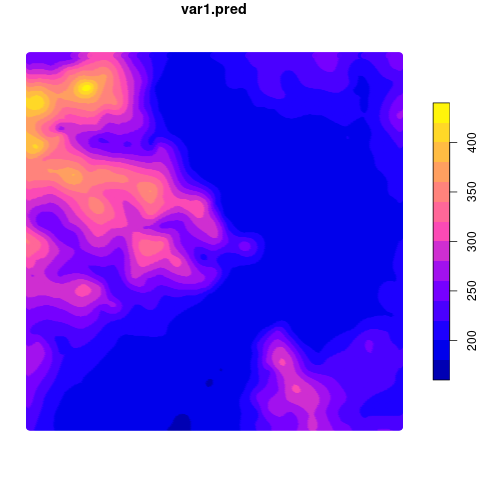

In [ ]:
%%R

z_sf <- st_as_sf(z, coords = c("x", "y"), crs = crs(elevrand))

plot(z_sf["var1.pred"])

Run the stochastic simulation n times

Calculate the mean and standard deviation of the simulatate surfaces

In [ ]:
%%R

execGRASS("g.list", type="raster", pattern="sgs_sim_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


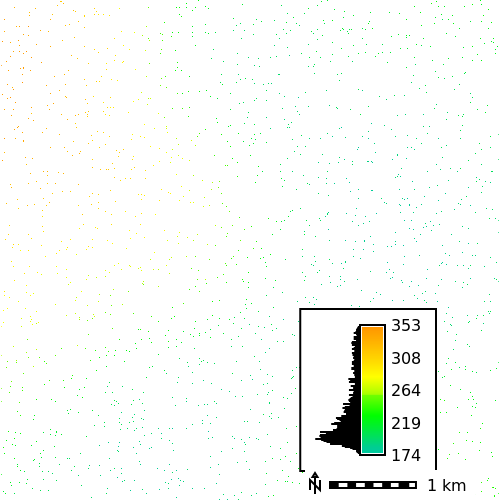

In [ ]:
m = gj.Map(use_region=True, height=500, width=500)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_mean", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

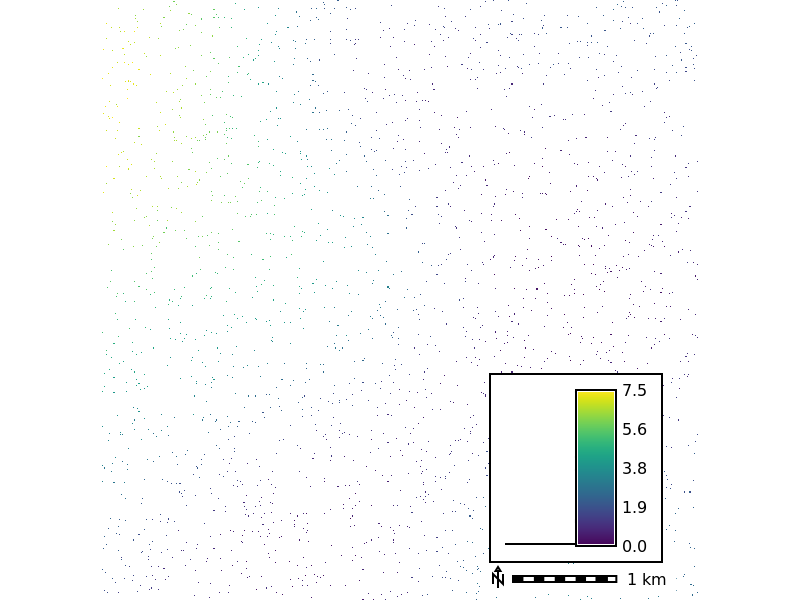

In [ ]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_std", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Generate streams for each DEM

In [ ]:
%%R
N.sim <- 10
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("sgs_sim_", i, sep=""),
 threshold=10000, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

Calculate the probablity and error

In [ ]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [ ]:
%%bash

r.colors simulated_mean rast=dem
r.colors sgs_sim_10 rast=dem
r.colors simulated_std co=bcyr -e
r.colors aspect_10 co=aspect
r.slope.aspect simulated_mean slo=slp_mean asp=asp_mean
r.slope.aspect sgs_sim_10 slo=slp_10 asp=asp_10
r.mapcalc "diff_spline_gsim = dem - simulated_mean"
r.colors diff_spline_gsim co=differences

Color table for raster map <simulated_mean> set to 'dem'
Color table for raster map <sgs_sim_10> set to 'dem'
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <simulated_std> set to 'bcyr'
ERROR: Raster map <aspect_10> not found
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_mean> complete
Slope raster map <slp_mean> complete
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_10> complete
Slope raster map <slp_10> complete
Color table for raster map <diff_spline_gsim> set to 'differences'


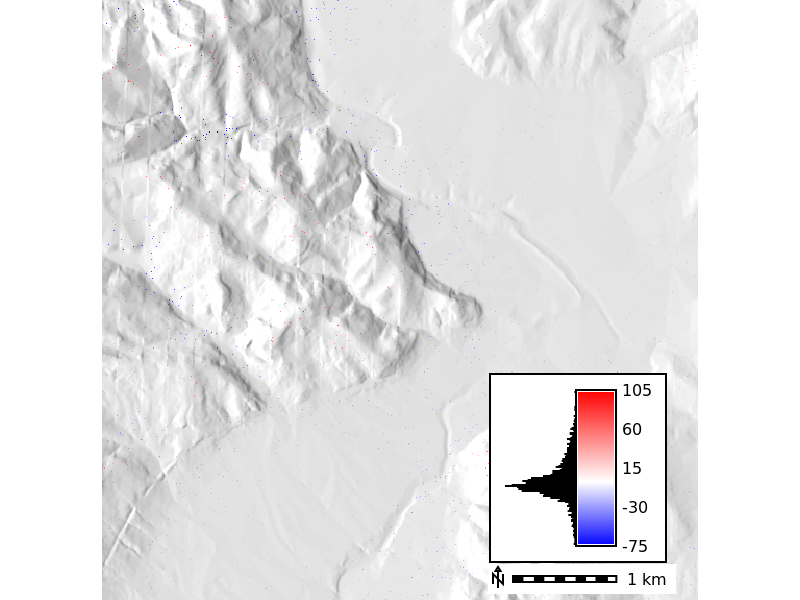

In [ ]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="diff_spline_gsim", brighten=30)
m.d_legend(raster="diff_spline_gsim", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float32>
Exporting raster data to RRASTER format...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File </tmp/Rtmp8OOieZ/file1ce84e1f9a8a.grd> created.


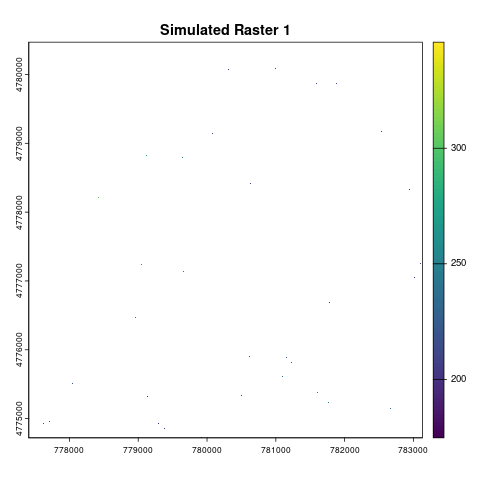

In [ ]:
%%R
sgs_sim_1 <- rgrass::read_RAST("sgs_sim_1")
plot(sgs_sim_1, main = "Simulated Raster 1")

Original Workflow:

https://github.com/ncsu-geoforall-lab/GIS714-assignments/blob/main/Surface_Water_Simulations/WaterSim-Geostatistical-Simulations.ipynb

TUTORIAL Option:

https://geobgu.xyz/r/spatial-interpolation-of-point-data.html